In [1]:
# Imports here
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import random
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms 
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter 
from tqdm import tqdm

from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# **Steps**

Step 1: Load Dataset <p>
Step 2: Transform the Dataset <p>
Step 3: Create Model <p>
Step 4: Train Model <p>
Step 5: Save the Model <p>
Step 6: Load the Model <p>


# Step 1: Load Dataset



In [3]:
data_dir = './dataset'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [4]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Step 2: Transform the Dataset

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225], calculated from the ImageNet images. These values will shift each color channel to be centered at 0 and range from -1 to 1.


In [5]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])


trainset = torchvision.datasets.ImageFolder(root=train_dir, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=0)

testset = torchvision.datasets.ImageFolder(root=valid_dir, transform=test_transforms)
validloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)

# Step 3: Create Model



In [6]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 56 * 56, 512)  # Adjusted this line
        self.fc2 = nn.Linear(512, 102)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [7]:
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Model instantiation and dummy input
model_test = CNNModel()
input_test = torch.randn(64, 3, 224, 224)  # Random input tensor

# Forward pass
output_test = model_test(input_test)
print(output_test.shape)


torch.Size([64, 102])


# Step 4: Train Model

In [9]:
import torch
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

num_epochs = 100

train_losses = []  # To store training losses
train_accuracies = []  # To store training accuracies
valid_losses = []  # To store validation losses
valid_accuracies = []  # To store validation accuracies

writer = SummaryWriter()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(tqdm(trainloader), 0):
        # Unpack data
        inputs, labels = data[0].to(device),data[1].to(device)
        
        # Apply mixup
        inputs_mixed, labels_a, labels_b, lam = mixup_data(inputs, labels, alpha=1.0)

        # Make sure there's no size mismatch
        assert inputs_mixed.size(0) == labels_a.size(0) == labels_b.size(0), "Size mismatch after mixup!"
        
        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs_mixed)

        # Compute mixup loss
        loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        # Print loss every 100 batches
        #if (i+1) % 100 == 0:
            #print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            #running_loss = 0.0
        # print("Inputs Mixed Shape:", inputs_mixed.shape)
        # print("Labels A Shape:", labels_a.shape)
        # print("Labels B Shape:", labels_b.shape)
        # print("Model Outputs Shape:", outputs.shape)
        
    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")
    
    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    
    with torch.no_grad():
        for inputs, labels in validloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    valid_accuracy = 100 * correct_valid / total_valid
    valid_losses.append(valid_loss / len(validloader))
    valid_accuracies.append(valid_accuracy)

    print(f"Validation Loss: {valid_loss / len(validloader):.4f}, Validation Accuracy: {valid_accuracy:.2f}%")

# After the training loop
df = pd.DataFrame({
    'Epoch': range(1, num_epochs + 1),
    'Training Loss': train_losses,
    'Training Accuracy': train_accuracies,
    'Validation Loss': valid_losses,
    'Validation Accuracy': valid_accuracies
})

# Save the DataFrame to a CSV file
csv_file = 'base_model_and_mix_up_data.csv'
df.to_csv(csv_file, index=False)

print(f'Training data saved to {csv_file}')


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [01:41<00:00,  2.02it/s]


Epoch 1/100, Training Loss: 4.7566, Training Accuracy: 2.69%
Validation Loss: 4.3513, Validation Accuracy: 4.52%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:49<00:00,  4.17it/s]


Epoch 2/100, Training Loss: 4.2571, Training Accuracy: 5.05%
Validation Loss: 3.8172, Validation Accuracy: 9.90%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.40it/s]


Epoch 3/100, Training Loss: 3.9963, Training Accuracy: 6.99%
Validation Loss: 3.3921, Validation Accuracy: 14.67%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.40it/s]


Epoch 4/100, Training Loss: 3.8728, Training Accuracy: 8.79%
Validation Loss: 3.2023, Validation Accuracy: 21.88%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.41it/s]


Epoch 5/100, Training Loss: 3.7326, Training Accuracy: 9.66%
Validation Loss: 2.8434, Validation Accuracy: 29.46%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.40it/s]


Epoch 6/100, Training Loss: 3.6562, Training Accuracy: 11.14%
Validation Loss: 2.7689, Validation Accuracy: 33.01%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.41it/s]


Epoch 7/100, Training Loss: 3.6268, Training Accuracy: 12.04%
Validation Loss: 2.7610, Validation Accuracy: 34.72%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:49<00:00,  4.15it/s]


Epoch 8/100, Training Loss: 3.5531, Training Accuracy: 12.77%
Validation Loss: 2.6788, Validation Accuracy: 32.64%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [01:33<00:00,  2.19it/s]


Epoch 9/100, Training Loss: 3.4842, Training Accuracy: 14.65%
Validation Loss: 2.3948, Validation Accuracy: 40.71%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.41it/s]


Epoch 10/100, Training Loss: 3.4661, Training Accuracy: 14.26%
Validation Loss: 2.4089, Validation Accuracy: 38.75%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.39it/s]


Epoch 11/100, Training Loss: 3.4532, Training Accuracy: 15.57%
Validation Loss: 2.2524, Validation Accuracy: 43.52%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.40it/s]


Epoch 12/100, Training Loss: 3.3665, Training Accuracy: 16.53%
Validation Loss: 2.2570, Validation Accuracy: 42.67%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:47<00:00,  4.34it/s]


Epoch 13/100, Training Loss: 3.4019, Training Accuracy: 17.02%
Validation Loss: 2.1668, Validation Accuracy: 43.15%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.40it/s]


Epoch 14/100, Training Loss: 3.3447, Training Accuracy: 18.13%
Validation Loss: 2.1606, Validation Accuracy: 45.84%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:47<00:00,  4.33it/s]


Epoch 15/100, Training Loss: 3.2689, Training Accuracy: 19.51%
Validation Loss: 1.9701, Validation Accuracy: 47.80%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.41it/s]


Epoch 16/100, Training Loss: 3.3261, Training Accuracy: 18.77%
Validation Loss: 2.0338, Validation Accuracy: 47.56%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.39it/s]


Epoch 17/100, Training Loss: 3.2550, Training Accuracy: 18.67%
Validation Loss: 1.9615, Validation Accuracy: 50.24%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.40it/s]


Epoch 18/100, Training Loss: 3.2125, Training Accuracy: 19.55%
Validation Loss: 1.9622, Validation Accuracy: 49.63%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.40it/s]


Epoch 19/100, Training Loss: 3.2238, Training Accuracy: 19.69%
Validation Loss: 1.8979, Validation Accuracy: 52.20%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.40it/s]


Epoch 20/100, Training Loss: 3.1348, Training Accuracy: 19.35%
Validation Loss: 1.7741, Validation Accuracy: 54.16%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.40it/s]


Epoch 21/100, Training Loss: 3.1226, Training Accuracy: 19.43%
Validation Loss: 1.7408, Validation Accuracy: 55.75%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.40it/s]


Epoch 22/100, Training Loss: 3.0996, Training Accuracy: 21.41%
Validation Loss: 1.7211, Validation Accuracy: 57.21%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.40it/s]


Epoch 23/100, Training Loss: 3.1036, Training Accuracy: 20.88%
Validation Loss: 1.7426, Validation Accuracy: 54.89%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.40it/s]


Epoch 24/100, Training Loss: 3.0553, Training Accuracy: 20.47%
Validation Loss: 1.7140, Validation Accuracy: 56.11%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.40it/s]


Epoch 25/100, Training Loss: 3.0275, Training Accuracy: 22.83%
Validation Loss: 1.7190, Validation Accuracy: 56.72%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.41it/s]


Epoch 26/100, Training Loss: 3.0678, Training Accuracy: 21.93%
Validation Loss: 1.6535, Validation Accuracy: 57.33%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.41it/s]


Epoch 27/100, Training Loss: 3.0319, Training Accuracy: 22.88%
Validation Loss: 1.6794, Validation Accuracy: 56.85%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.41it/s]


Epoch 28/100, Training Loss: 2.9348, Training Accuracy: 22.51%
Validation Loss: 1.5485, Validation Accuracy: 61.00%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.41it/s]


Epoch 29/100, Training Loss: 3.0267, Training Accuracy: 23.96%
Validation Loss: 1.5792, Validation Accuracy: 60.51%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.42it/s]


Epoch 30/100, Training Loss: 3.0070, Training Accuracy: 23.08%
Validation Loss: 1.5242, Validation Accuracy: 61.12%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.38it/s]


Epoch 31/100, Training Loss: 2.9034, Training Accuracy: 24.21%
Validation Loss: 1.5109, Validation Accuracy: 60.88%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.41it/s]


Epoch 32/100, Training Loss: 2.9531, Training Accuracy: 24.50%
Validation Loss: 1.5702, Validation Accuracy: 60.64%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.41it/s]


Epoch 33/100, Training Loss: 2.9506, Training Accuracy: 21.46%
Validation Loss: 1.4818, Validation Accuracy: 62.47%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.41it/s]


Epoch 34/100, Training Loss: 2.9078, Training Accuracy: 27.38%
Validation Loss: 1.4292, Validation Accuracy: 63.57%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.43it/s]


Epoch 35/100, Training Loss: 2.8705, Training Accuracy: 23.98%
Validation Loss: 1.4953, Validation Accuracy: 64.06%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.39it/s]


Epoch 36/100, Training Loss: 2.8349, Training Accuracy: 26.25%
Validation Loss: 1.4479, Validation Accuracy: 63.57%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.38it/s]


Epoch 37/100, Training Loss: 2.9066, Training Accuracy: 24.97%
Validation Loss: 1.4147, Validation Accuracy: 63.94%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.40it/s]


Epoch 38/100, Training Loss: 2.9236, Training Accuracy: 21.78%
Validation Loss: 1.4352, Validation Accuracy: 64.79%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.40it/s]


Epoch 39/100, Training Loss: 2.8316, Training Accuracy: 24.76%
Validation Loss: 1.4466, Validation Accuracy: 64.06%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.41it/s]


Epoch 40/100, Training Loss: 2.8683, Training Accuracy: 26.89%
Validation Loss: 1.4403, Validation Accuracy: 62.96%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.41it/s]


Epoch 41/100, Training Loss: 2.9095, Training Accuracy: 23.50%
Validation Loss: 1.3605, Validation Accuracy: 66.87%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.38it/s]


Epoch 42/100, Training Loss: 2.8504, Training Accuracy: 26.65%
Validation Loss: 1.4234, Validation Accuracy: 65.28%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.39it/s]


Epoch 43/100, Training Loss: 2.8027, Training Accuracy: 25.82%
Validation Loss: 1.3527, Validation Accuracy: 64.30%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.40it/s]


Epoch 44/100, Training Loss: 2.7759, Training Accuracy: 27.29%
Validation Loss: 1.3584, Validation Accuracy: 66.01%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.39it/s]


Epoch 45/100, Training Loss: 2.7563, Training Accuracy: 28.59%
Validation Loss: 1.3296, Validation Accuracy: 66.99%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.39it/s]


Epoch 46/100, Training Loss: 2.8338, Training Accuracy: 26.36%
Validation Loss: 1.2828, Validation Accuracy: 66.87%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.39it/s]


Epoch 47/100, Training Loss: 2.7362, Training Accuracy: 30.49%
Validation Loss: 1.3163, Validation Accuracy: 65.04%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.41it/s]


Epoch 48/100, Training Loss: 2.7343, Training Accuracy: 25.31%
Validation Loss: 1.3713, Validation Accuracy: 63.45%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.38it/s]


Epoch 49/100, Training Loss: 2.7001, Training Accuracy: 24.73%
Validation Loss: 1.2539, Validation Accuracy: 66.99%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.40it/s]


Epoch 50/100, Training Loss: 2.8219, Training Accuracy: 24.79%
Validation Loss: 1.3239, Validation Accuracy: 66.26%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.40it/s]


Epoch 51/100, Training Loss: 2.7612, Training Accuracy: 26.63%
Validation Loss: 1.2493, Validation Accuracy: 67.24%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.41it/s]


Epoch 52/100, Training Loss: 2.7919, Training Accuracy: 24.66%
Validation Loss: 1.2633, Validation Accuracy: 68.09%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.42it/s]


Epoch 53/100, Training Loss: 2.6945, Training Accuracy: 28.14%
Validation Loss: 1.2956, Validation Accuracy: 66.50%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.42it/s]


Epoch 54/100, Training Loss: 2.7326, Training Accuracy: 23.03%
Validation Loss: 1.2353, Validation Accuracy: 69.68%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.40it/s]


Epoch 55/100, Training Loss: 2.7600, Training Accuracy: 29.98%
Validation Loss: 1.1825, Validation Accuracy: 68.09%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.42it/s]


Epoch 56/100, Training Loss: 2.7320, Training Accuracy: 28.54%
Validation Loss: 1.3586, Validation Accuracy: 66.75%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.41it/s]


Epoch 57/100, Training Loss: 2.6931, Training Accuracy: 28.43%
Validation Loss: 1.2126, Validation Accuracy: 70.54%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.42it/s]


Epoch 58/100, Training Loss: 2.7663, Training Accuracy: 28.72%
Validation Loss: 1.2163, Validation Accuracy: 69.93%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.42it/s]


Epoch 59/100, Training Loss: 2.6679, Training Accuracy: 30.65%
Validation Loss: 1.1821, Validation Accuracy: 69.44%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:47<00:00,  4.35it/s]


Epoch 60/100, Training Loss: 2.6875, Training Accuracy: 28.95%
Validation Loss: 1.2413, Validation Accuracy: 68.83%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:50<00:00,  4.04it/s]


Epoch 61/100, Training Loss: 2.7204, Training Accuracy: 29.98%
Validation Loss: 1.2399, Validation Accuracy: 68.70%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:45<00:00,  4.46it/s]


Epoch 62/100, Training Loss: 2.7494, Training Accuracy: 27.81%
Validation Loss: 1.1790, Validation Accuracy: 70.90%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:45<00:00,  4.49it/s]


Epoch 63/100, Training Loss: 2.7201, Training Accuracy: 24.60%
Validation Loss: 1.2136, Validation Accuracy: 67.73%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:45<00:00,  4.51it/s]


Epoch 64/100, Training Loss: 2.7085, Training Accuracy: 25.03%
Validation Loss: 1.1546, Validation Accuracy: 70.17%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:45<00:00,  4.50it/s]


Epoch 65/100, Training Loss: 2.6650, Training Accuracy: 33.53%
Validation Loss: 1.1794, Validation Accuracy: 69.07%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:45<00:00,  4.49it/s]


Epoch 66/100, Training Loss: 2.7187, Training Accuracy: 27.05%
Validation Loss: 1.2021, Validation Accuracy: 69.68%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:45<00:00,  4.47it/s]


Epoch 67/100, Training Loss: 2.7258, Training Accuracy: 26.83%
Validation Loss: 1.0853, Validation Accuracy: 72.00%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:45<00:00,  4.48it/s]


Epoch 68/100, Training Loss: 2.7299, Training Accuracy: 28.71%
Validation Loss: 1.1202, Validation Accuracy: 71.27%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:45<00:00,  4.48it/s]


Epoch 69/100, Training Loss: 2.6734, Training Accuracy: 29.59%
Validation Loss: 1.1900, Validation Accuracy: 69.93%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:47<00:00,  4.27it/s]


Epoch 70/100, Training Loss: 2.6087, Training Accuracy: 26.18%
Validation Loss: 1.1814, Validation Accuracy: 69.68%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:48<00:00,  4.26it/s]


Epoch 71/100, Training Loss: 2.7545, Training Accuracy: 28.33%
Validation Loss: 1.1335, Validation Accuracy: 71.03%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:48<00:00,  4.26it/s]


Epoch 72/100, Training Loss: 2.7326, Training Accuracy: 27.24%
Validation Loss: 1.1661, Validation Accuracy: 71.39%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:48<00:00,  4.25it/s]


Epoch 73/100, Training Loss: 2.6183, Training Accuracy: 30.72%
Validation Loss: 1.1294, Validation Accuracy: 70.54%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:50<00:00,  4.10it/s]


Epoch 74/100, Training Loss: 2.6338, Training Accuracy: 29.12%
Validation Loss: 1.1375, Validation Accuracy: 71.15%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:49<00:00,  4.17it/s]


Epoch 75/100, Training Loss: 2.6298, Training Accuracy: 30.60%
Validation Loss: 1.0906, Validation Accuracy: 72.13%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:49<00:00,  4.13it/s]


Epoch 76/100, Training Loss: 2.6866, Training Accuracy: 27.63%
Validation Loss: 1.1588, Validation Accuracy: 69.93%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:48<00:00,  4.26it/s]


Epoch 77/100, Training Loss: 2.7435, Training Accuracy: 27.47%
Validation Loss: 1.1653, Validation Accuracy: 69.56%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:49<00:00,  4.12it/s]


Epoch 78/100, Training Loss: 2.7008, Training Accuracy: 28.62%
Validation Loss: 1.1522, Validation Accuracy: 72.00%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:50<00:00,  4.10it/s]


Epoch 79/100, Training Loss: 2.5785, Training Accuracy: 30.53%
Validation Loss: 1.0645, Validation Accuracy: 73.23%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:47<00:00,  4.30it/s]


Epoch 80/100, Training Loss: 2.6165, Training Accuracy: 31.32%
Validation Loss: 1.0799, Validation Accuracy: 74.21%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:48<00:00,  4.22it/s]


Epoch 81/100, Training Loss: 2.6631, Training Accuracy: 31.81%
Validation Loss: 1.1010, Validation Accuracy: 72.13%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:47<00:00,  4.30it/s]


Epoch 82/100, Training Loss: 2.6422, Training Accuracy: 27.08%
Validation Loss: 1.1391, Validation Accuracy: 71.15%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:48<00:00,  4.20it/s]


Epoch 83/100, Training Loss: 2.6322, Training Accuracy: 32.08%
Validation Loss: 1.0976, Validation Accuracy: 73.72%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:48<00:00,  4.21it/s]


Epoch 84/100, Training Loss: 2.5798, Training Accuracy: 31.99%
Validation Loss: 1.0952, Validation Accuracy: 72.37%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:47<00:00,  4.28it/s]


Epoch 85/100, Training Loss: 2.6740, Training Accuracy: 29.14%
Validation Loss: 1.0918, Validation Accuracy: 73.11%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.42it/s]


Epoch 86/100, Training Loss: 2.6212, Training Accuracy: 30.45%
Validation Loss: 1.0921, Validation Accuracy: 73.23%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.42it/s]


Epoch 87/100, Training Loss: 2.6512, Training Accuracy: 27.61%
Validation Loss: 1.1736, Validation Accuracy: 70.78%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.43it/s]


Epoch 88/100, Training Loss: 2.5314, Training Accuracy: 29.72%
Validation Loss: 1.0232, Validation Accuracy: 73.35%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.42it/s]


Epoch 89/100, Training Loss: 2.6394, Training Accuracy: 29.76%
Validation Loss: 1.0640, Validation Accuracy: 74.33%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.42it/s]


Epoch 90/100, Training Loss: 2.6897, Training Accuracy: 30.83%
Validation Loss: 1.1346, Validation Accuracy: 71.15%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.43it/s]


Epoch 91/100, Training Loss: 2.6798, Training Accuracy: 27.55%
Validation Loss: 1.1021, Validation Accuracy: 72.37%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.43it/s]


Epoch 92/100, Training Loss: 2.6121, Training Accuracy: 26.89%
Validation Loss: 1.0994, Validation Accuracy: 72.74%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.44it/s]


Epoch 93/100, Training Loss: 2.6274, Training Accuracy: 31.21%
Validation Loss: 1.0751, Validation Accuracy: 73.59%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.44it/s]


Epoch 94/100, Training Loss: 2.6404, Training Accuracy: 29.33%
Validation Loss: 1.0300, Validation Accuracy: 73.23%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.42it/s]


Epoch 95/100, Training Loss: 2.6357, Training Accuracy: 31.56%
Validation Loss: 1.0865, Validation Accuracy: 73.84%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.44it/s]


Epoch 96/100, Training Loss: 2.6326, Training Accuracy: 30.94%
Validation Loss: 1.1108, Validation Accuracy: 74.45%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.42it/s]


Epoch 97/100, Training Loss: 2.6732, Training Accuracy: 27.58%
Validation Loss: 1.0380, Validation Accuracy: 73.59%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.42it/s]


Epoch 98/100, Training Loss: 2.6090, Training Accuracy: 29.88%
Validation Loss: 1.0912, Validation Accuracy: 73.96%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.43it/s]


Epoch 99/100, Training Loss: 2.5785, Training Accuracy: 33.91%
Validation Loss: 1.0868, Validation Accuracy: 73.59%


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:46<00:00,  4.43it/s]


Epoch 100/100, Training Loss: 2.5100, Training Accuracy: 29.96%
Validation Loss: 1.0000, Validation Accuracy: 75.79%
Training data saved to base_model_and_mix_up_data.csv


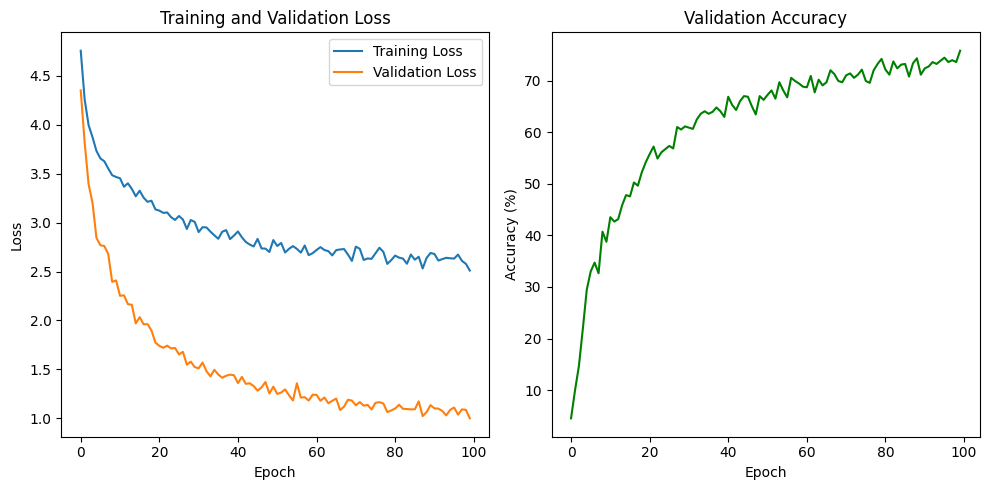

In [10]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(valid_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()

In [11]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)
print(labels.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [12]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
  for support_set, query_set in validloader:
      support_set, query_set = support_set.to(device), query_set.to(device)
      embeddings = model(support_set)
      _, predicted = torch.max(embeddings, 1)
      total += query_set.size(0)
      correct += (predicted == query_set).sum().item()
print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 75 %


# Step 5: Save the Model

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: image_datasets['train'].class_to_idx. You can attach this to the model as an attribute which makes inference easier later on.

model.class_to_idx = image_datasets['train'].class_to_idx

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, optimizer.state_dict. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [13]:
# Save the trained model to a file
torch.save(model.state_dict(), 'base_model_and_mix_up_model.pth')

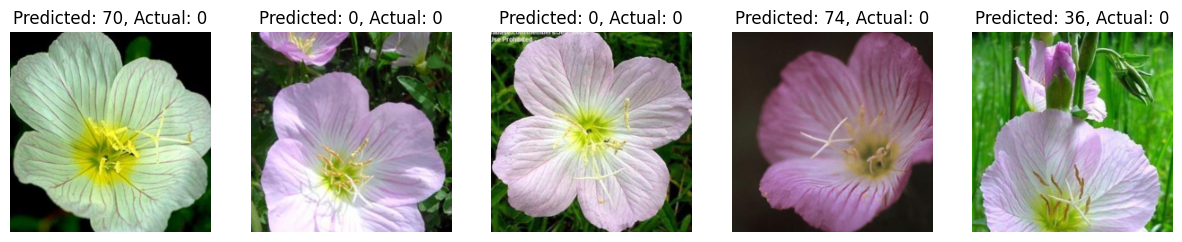

In [14]:
# Set the model to evaluation mode
model.eval()

# Function to display an image
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    # PyTorch tensors assume the color channel is the first dimension
    image = image.cpu().numpy().transpose((1, 2, 0))
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    if title:
        ax.set_title(title)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

# Function to make predictions and display images
def visualize_predictions(model, dataloader, num_images=5):
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    _, preds = torch.max(output, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        imshow(images[i], ax=axes[i], title=f'Predicted: {preds[i]}, Actual: {labels[i]}')

# Visualize model predictions on a few validation images
visualize_predictions(model, validloader, num_images=5)

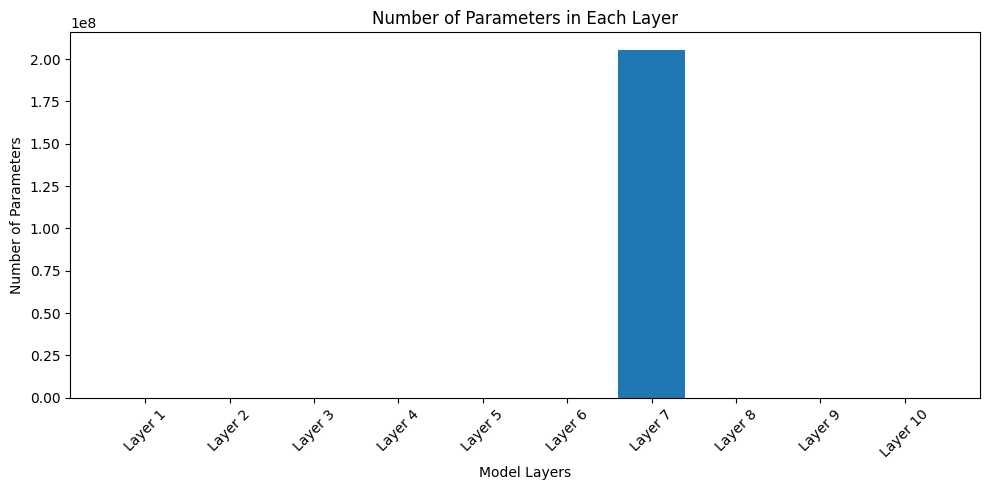

In [15]:
# Get the model's parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = [p.numel() for p in model_parameters]

# Create labels for each layer
layer_labels = [f'Layer {i}' for i in range(1, len(params) + 1)]

# Create a bar graph
plt.figure(figsize=(10, 5))
plt.bar(layer_labels, params)
plt.xlabel('Model Layers')
plt.ylabel('Number of Parameters')
plt.title('Number of Parameters in Each Layer')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the graph
plt.show()

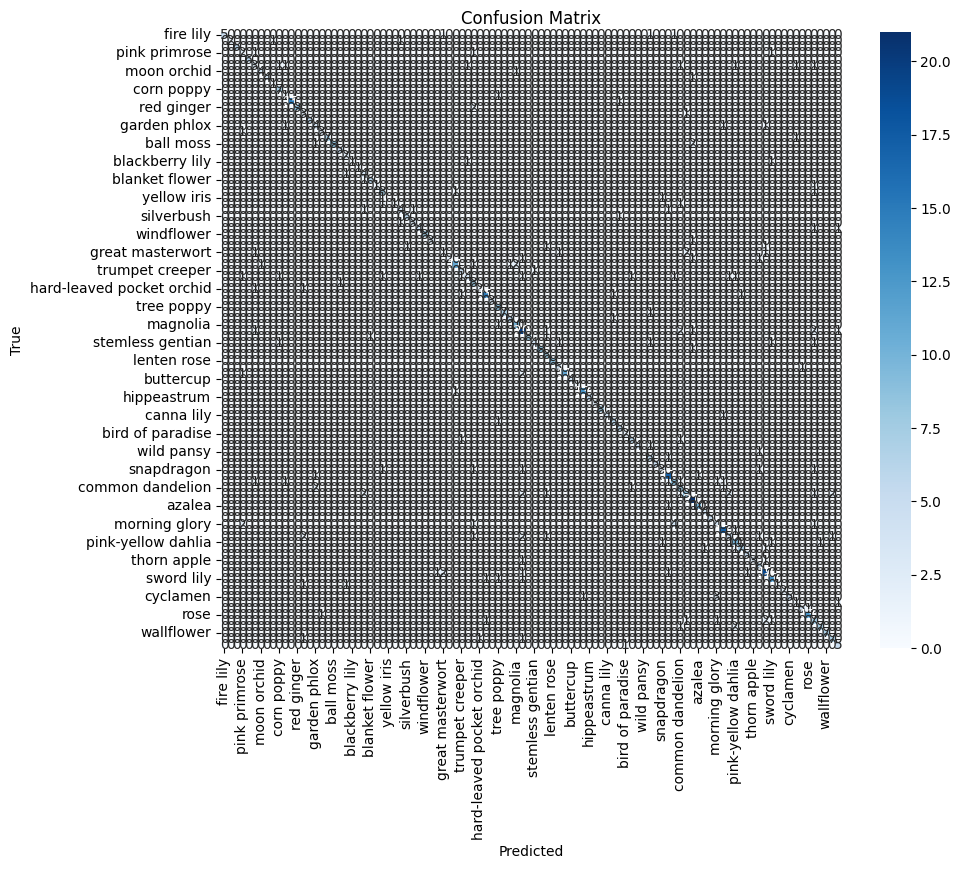

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Set the model to evaluation mode
model.eval()

# Initialize variables to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset to collect labels
with torch.no_grad():
    for images, labels in validloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Convert the confusion matrix to a Pandas DataFrame for visualization
cm_df = pd.DataFrame(cm, index=cat_to_name.values(), columns=cat_to_name.values())

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [17]:
writer.close()

# Step 6: Load the Model
At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [18]:
#model = torch.load('epoch100.pth').to(device)
# If you also saved other attributes like optimizer state
#model.state_dict()

